# Molecule property regression with message-passing network

### Preamble

In [1]:
### Colab
! pip3 install  dgl -f https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.3/cu121/repo.html


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import dgl
from dgl.data import QM9EdgeDataset
from tqdm import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

## QM9EdgeDataset
DGL provides a preloaded interface to this dataset of 130k molecules.
- https://docs.dgl.ai/en/0.8.x/generated/dgl.data.QM9EdgeDataset.html
- http://quantum-machine.org/datasets/

We want to train a graph neural network to regress the magnitude of the electric dipole moment $|\vec{\mu}|$ of the molecule, where:

$\vec{\mu} = \sum_{i} q_i \vec{x_i}$

The atoms (nodes) in each molecule (graph) contain the following features:
- `pos`: spatial coordinates (3 numbers)
- `attr`: additional properties (11 numbers)

For our task, we will restrict ourselves to _purely_ the spatial coordinates and the atomic number as input features.

In [4]:
data = QM9EdgeDataset(label_keys=['mu'])

Done loading data from cached files.


In [5]:
len(data)

130831

In [6]:
g, labels = data.__getitem__(100000)

Note: I needed `pip install --upgrade nbformat` after getting `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`

## Plotly visualization
Code in `visualizer.py`

In [7]:
from visualizer import draw_plotly
draw_plotly(g)

## Message-passing model
This simple graph neural network consists of three main network components:
1) Node feature encoding
2) Message passing blocks
3) Graph-level prediction

<img src="https://github.com/WeizmannMLcourse/MLCourse_2024/blob/main/Tutorial10_graphs_with_DGL/model.jpeg?raw=1">

In [8]:
from model import MoleculeMPNN

In [9]:
net = MoleculeMPNN()

In [10]:
### number of parameters ###
sum(p.numel() for p in net.parameters())

371713

In [11]:
### Modified from https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html ###
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.row_stack(labels)
    return batched_graph, labels

### Train-val-test splits

In [12]:
train_dataset = torch.utils.data.Subset(data,range(100000))
valid_dataset = torch.utils.data.Subset(data,range(100000,105000))
test_dataset = torch.utils.data.Subset(data,range(110000,len(data)-1))

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=collate, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, collate_fn=collate, num_workers=2)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, collate_fn=collate, num_workers=0)

In [13]:
net(g)

tensor([[-0.0320]], grad_fn=<AddmmBackward0>)

## Training

In [14]:
from training import train_valid_loop

train_loss, valid_loss = train_valid_loop(net, train_dataloader, valid_dataloader, 60)

Found GPU!


  2%|▏         | 1/60 [01:17<1:15:49, 77.10s/it]

Epoch:  0  Train loss:  2.1373814237117768  Valid loss:  1.1719223022460938


  3%|▎         | 2/60 [02:28<1:11:18, 73.77s/it]

Epoch:  1  Train loss:  1.284877939939499  Valid loss:  1.0707561659812928


  5%|▌         | 3/60 [03:32<1:06:00, 69.48s/it]

Epoch:  2  Train loss:  1.2360877474546432  Valid loss:  0.9967940056324005


  7%|▋         | 4/60 [04:37<1:02:51, 67.35s/it]

Epoch:  3  Train loss:  1.1829971894025804  Valid loss:  0.9965782284736633


  8%|▊         | 5/60 [05:40<1:00:33, 66.07s/it]

Epoch:  4  Train loss:  1.1356297882795334  Valid loss:  0.9365548741817474


 10%|█         | 6/60 [06:44<58:44, 65.27s/it]  

Epoch:  5  Train loss:  1.089813397884369  Valid loss:  0.9363656830787659


 12%|█▏        | 7/60 [07:49<57:32, 65.15s/it]

Epoch:  6  Train loss:  1.0661965841054917  Valid loss:  0.8504298961162567


 13%|█▎        | 8/60 [08:53<56:03, 64.68s/it]

Epoch:  7  Train loss:  0.9954934145212173  Valid loss:  0.9271290254592895


 15%|█▌        | 9/60 [09:55<54:23, 64.00s/it]

Epoch:  8  Train loss:  0.9656295845508576  Valid loss:  0.7943667697906495


 17%|█▋        | 10/60 [10:59<53:17, 63.96s/it]

Epoch:  9  Train loss:  0.9482388553619385  Valid loss:  0.7967459952831268


 18%|█▊        | 11/60 [12:02<52:06, 63.80s/it]

Epoch:  10  Train loss:  0.9305476485490799  Valid loss:  0.8521691370010376


 20%|██        | 12/60 [13:06<50:56, 63.67s/it]

Epoch:  11  Train loss:  0.9173530913591385  Valid loss:  0.7335980260372161


 22%|██▏       | 13/60 [14:08<49:36, 63.33s/it]

Epoch:  12  Train loss:  0.8795680512189865  Valid loss:  0.697435222864151


 23%|██▎       | 14/60 [15:13<48:46, 63.62s/it]

Epoch:  13  Train loss:  0.8339942095279693  Valid loss:  0.7317462861537933


 25%|██▌       | 15/60 [16:17<47:49, 63.76s/it]

Epoch:  14  Train loss:  0.8396145876646042  Valid loss:  0.7640520465373993


 27%|██▋       | 16/60 [17:21<46:54, 63.97s/it]

Epoch:  15  Train loss:  0.8121068925261498  Valid loss:  0.7222025287151337


 28%|██▊       | 17/60 [18:25<45:51, 63.98s/it]

Epoch:  16  Train loss:  0.7844577147960663  Valid loss:  0.6742380583286285


 30%|███       | 18/60 [19:30<44:57, 64.22s/it]

Epoch:  17  Train loss:  0.8248024591207505  Valid loss:  0.7076214981079102


 32%|███▏      | 19/60 [20:35<44:05, 64.54s/it]

Epoch:  18  Train loss:  0.8082410324215888  Valid loss:  0.6648886215686798


 33%|███▎      | 20/60 [21:40<43:08, 64.70s/it]

Epoch:  19  Train loss:  0.7349688432812691  Valid loss:  0.67251326918602


 35%|███▌      | 21/60 [22:45<41:58, 64.59s/it]

Epoch:  20  Train loss:  0.7127762414216995  Valid loss:  0.6483102381229401


 37%|███▋      | 22/60 [23:48<40:36, 64.12s/it]

Epoch:  21  Train loss:  0.7321998140811921  Valid loss:  0.7145048141479492


 38%|███▊      | 23/60 [24:51<39:25, 63.94s/it]

Epoch:  22  Train loss:  0.704736328125  Valid loss:  0.7566517043113709


 40%|████      | 24/60 [25:54<38:09, 63.60s/it]

Epoch:  23  Train loss:  0.6718028499484062  Valid loss:  0.6268106019496917


 42%|████▏     | 25/60 [26:57<37:00, 63.44s/it]

Epoch:  24  Train loss:  0.6555816075801849  Valid loss:  0.6080364346504211


 43%|████▎     | 26/60 [27:59<35:41, 62.97s/it]

Epoch:  25  Train loss:  0.6269799020290375  Valid loss:  0.6369166040420532


 45%|████▌     | 27/60 [29:02<34:38, 62.99s/it]

Epoch:  26  Train loss:  0.6260898613929748  Valid loss:  0.7376395833492279


 47%|████▋     | 28/60 [30:06<33:45, 63.30s/it]

Epoch:  27  Train loss:  0.618912609577179  Valid loss:  0.5938786208629608


 48%|████▊     | 29/60 [31:07<32:20, 62.59s/it]

Epoch:  28  Train loss:  0.594702566921711  Valid loss:  0.5842171275615692


 50%|█████     | 30/60 [32:11<31:30, 63.02s/it]

Epoch:  29  Train loss:  0.5984274877905845  Valid loss:  0.6588117158412934


 52%|█████▏    | 31/60 [33:13<30:21, 62.82s/it]

Epoch:  30  Train loss:  0.5647591924667359  Valid loss:  0.6296463596820832


 53%|█████▎    | 32/60 [34:17<29:24, 63.01s/it]

Epoch:  31  Train loss:  0.5471686210632324  Valid loss:  0.6253039801120758


 55%|█████▌    | 33/60 [35:20<28:27, 63.22s/it]

Epoch:  32  Train loss:  0.5602512351870537  Valid loss:  0.635276870727539


 57%|█████▋    | 34/60 [36:24<27:25, 63.28s/it]

Epoch:  33  Train loss:  0.8062365927100181  Valid loss:  0.6620007538795472


 58%|█████▊    | 35/60 [37:26<26:11, 62.88s/it]

Epoch:  34  Train loss:  0.5661299432516098  Valid loss:  0.5793743717670441


 60%|██████    | 36/60 [38:29<25:13, 63.04s/it]

Epoch:  35  Train loss:  0.5176665216088295  Valid loss:  0.5703039479255676


 62%|██████▏   | 37/60 [39:33<24:12, 63.14s/it]

Epoch:  36  Train loss:  0.5071779621243477  Valid loss:  0.5514023005962372


 63%|██████▎   | 38/60 [40:38<23:21, 63.72s/it]

Epoch:  37  Train loss:  0.501350862622261  Valid loss:  0.5824821281433106


 65%|██████▌   | 39/60 [41:42<22:24, 64.01s/it]

Epoch:  38  Train loss:  0.5995346313714981  Valid loss:  0.6245629918575287


 67%|██████▋   | 40/60 [42:46<21:16, 63.80s/it]

Epoch:  39  Train loss:  0.4782844253182411  Valid loss:  0.5858954238891602


 68%|██████▊   | 41/60 [43:50<20:15, 63.99s/it]

Epoch:  40  Train loss:  0.4783279913067818  Valid loss:  0.6039896774291992


 70%|███████   | 42/60 [44:55<19:17, 64.32s/it]

Epoch:  41  Train loss:  0.4488563460111618  Valid loss:  0.5467322266101837


 72%|███████▏  | 43/60 [46:00<18:16, 64.48s/it]

Epoch:  42  Train loss:  0.45517939496040344  Valid loss:  0.7355094230175019


 73%|███████▎  | 44/60 [47:04<17:09, 64.34s/it]

Epoch:  43  Train loss:  0.5034045276045799  Valid loss:  0.5499902880191803


 75%|███████▌  | 45/60 [48:08<16:03, 64.25s/it]

Epoch:  44  Train loss:  0.4330575320124626  Valid loss:  0.6694608068466187


 77%|███████▋  | 46/60 [49:15<15:11, 65.09s/it]

Epoch:  45  Train loss:  0.5452697862982749  Valid loss:  0.5458189010620117


 78%|███████▊  | 47/60 [50:19<14:00, 64.64s/it]

Epoch:  46  Train loss:  0.41515186977386476  Valid loss:  0.5676490128040313


 80%|████████  | 48/60 [51:23<12:53, 64.49s/it]

Epoch:  47  Train loss:  0.4098503211438656  Valid loss:  0.536641172170639


 82%|████████▏ | 49/60 [52:26<11:45, 64.15s/it]

Epoch:  48  Train loss:  0.39858180344104766  Valid loss:  0.5525434494018555


 83%|████████▎ | 50/60 [53:32<10:46, 64.66s/it]

Epoch:  49  Train loss:  0.41426837134361266  Valid loss:  0.532695381641388


 85%|████████▌ | 51/60 [54:36<09:38, 64.32s/it]

Epoch:  50  Train loss:  0.3789533109664917  Valid loss:  0.47935141146183013


 87%|████████▋ | 52/60 [55:39<08:33, 64.17s/it]

Epoch:  51  Train loss:  0.3777516783475876  Valid loss:  0.5243636500835419


 88%|████████▊ | 53/60 [56:43<07:27, 63.86s/it]

Epoch:  52  Train loss:  0.37182027161121367  Valid loss:  0.503716162443161


 90%|█████████ | 54/60 [57:45<06:20, 63.42s/it]

Epoch:  53  Train loss:  0.3744707393348217  Valid loss:  0.5054369544982911


 92%|█████████▏| 55/60 [58:51<05:21, 64.22s/it]

Epoch:  54  Train loss:  0.3557858644425869  Valid loss:  0.5215938258171081


 93%|█████████▎| 56/60 [59:54<04:14, 63.72s/it]

Epoch:  55  Train loss:  0.3418346831798553  Valid loss:  0.5096210515499116


 95%|█████████▌| 57/60 [1:00:57<03:10, 63.65s/it]

Epoch:  56  Train loss:  0.3559099350273609  Valid loss:  0.6122074770927429


 97%|█████████▋| 58/60 [1:01:59<02:06, 63.10s/it]

Epoch:  57  Train loss:  0.3527812341451645  Valid loss:  0.5369656765460968


 98%|█████████▊| 59/60 [1:03:04<01:03, 63.57s/it]

Epoch:  58  Train loss:  0.3374334660768509  Valid loss:  0.49677942395210267


100%|██████████| 60/60 [1:04:06<00:00, 64.11s/it]

Epoch:  59  Train loss:  0.32281147769093516  Valid loss:  0.495280824303627


In [15]:
### Reload stored values ###
train_loss = np.load('train_loss.npy')
valid_loss = np.load('valid_loss.npy')

In [16]:
### Load saved model ###
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

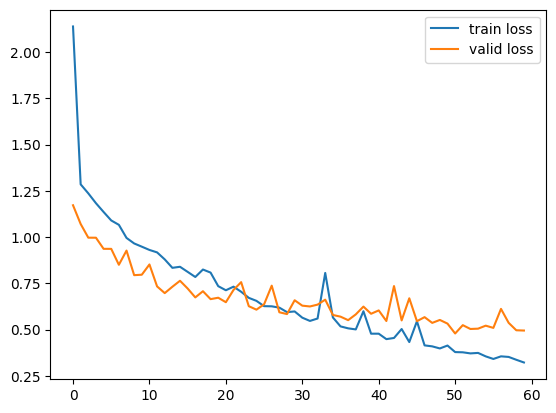

In [17]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss,label='train loss')
axes.plot(range(len(valid_loss)),valid_loss,label='valid loss')
#axes.set_yscale('log')
#axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

## Performance evaluation

In [18]:
preds, trues = [], []

for i in tqdm(range(len(test_dataset))):
    g, labels = test_dataset.__getitem__(i)
    preds.append(net(g).detach().numpy().item())
    trues.append(labels.item())

preds = np.array(preds)
trues = np.array(trues)

100%|██████████| 20830/20830 [05:12<00:00, 66.59it/s]


### Predicted vs. true scatter plot

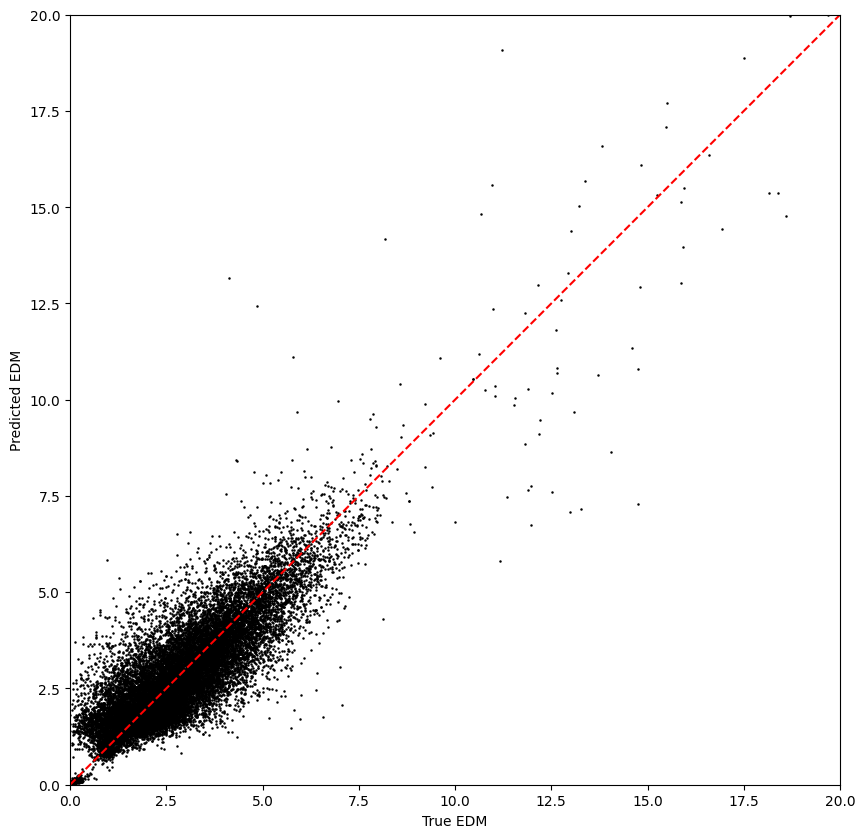

In [19]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(trues,preds,s=0.6,c='black')
axes.plot([0,20],[0,20],c='red',ls='--')
axes.set_xlabel('True EDM')
axes.set_ylabel('Predicted EDM')
axes.set_xlim(0,20)
axes.set_ylim(0,20)
axes.set_aspect('equal')

### Residual distribution

Text(0.5, 0, '(pred - true) / true')

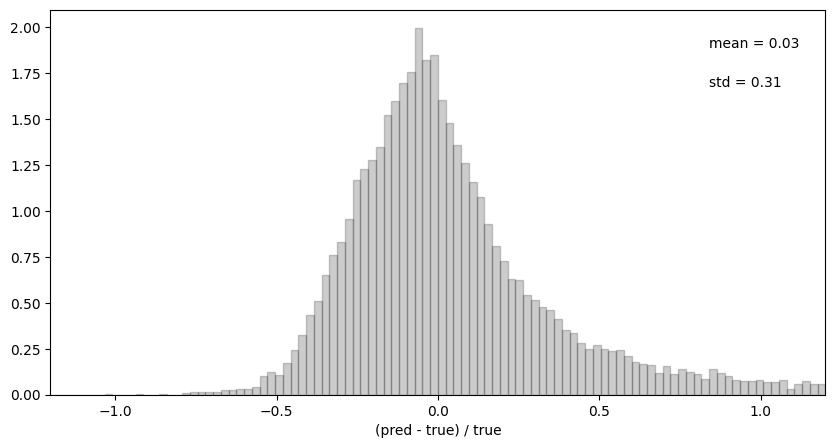

In [20]:
resids = (preds-trues)/(trues+1e-6)
resids = resids[abs(resids) < 1.2]

fig, axes = plt.subplots(figsize=(10,5))
h = axes.hist(resids,bins=100,range=(-1.2,1.2),facecolor='black',alpha=0.2,density=True,lw=1,edgecolor='black')
axes.set_xlim(-1.2,1.2)
axes.text(0.85,0.9,'mean = {:.2f}'.format(np.mean(resids)),transform=axes.transAxes)
axes.text(0.85,0.8,'std = {:.2f}'.format(np.std(resids)),transform=axes.transAxes)
axes.set_xlabel('(pred - true) / true')